# Final Project-Katerina Uruci, Abdullah Nuhin

In [158]:
import yfinance as yf 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

Steps 1 and 2 

In [2]:
ivv_etf = yf.download('iVV', period='5y')['Adj Close']


[*********************100%%**********************]  1 of 1 completed


In [8]:
ivv_assets_df = pd.read_csv('IVV_holdings.csv')[['Ticker', 'Name']].dropna()
ivv_assets_df = ivv_assets_df.drop(index=ivv_assets_df.loc[ivv_assets_df['Ticker'].isin(['DISH', 'UBFUT', 'ABC', 'BRKB', 'BFB', 'PKI', 'ESM3', 'RE', 'CDAY', 'XTSLA', 'ATVI', 'PEAK'])].index.tolist())

ivv_asset_data = yf.download(tickers=ivv_assets_df['Ticker'].tolist(), period='5y')['Adj Close']  # accounting for the previous 5 years worth of data to help with the backtest

[*********************100%%**********************]  495 of 495 completed


Step 3 to 6 


We have used the formula of 
Price Momentum = (CP - CPn) / CPn

Where:

CP = Closing price in the current period
CPn = Closing price N periods ago

In [154]:
class Portfolio:
    def __init__(self, etf_name, etf_data, etf_assets_df, etf_assets_data_df):
        # Initialize with ETF name, data, and assets
        self.etf_name = etf_name
        self.etf_data = etf_data  # ETF data without asset info
        self.etf_assets_df = etf_assets_df  # Tickers and Names for ETF assets
        self.etf_assets_data_df = etf_assets_data_df  # Adjusted Close Prices
        
        # Create DataFrame for asset info, indexed by Ticker
        self.etf_asset_info = pd.DataFrame(index=self.etf_assets_df['Ticker'])
        
        # Ensure the index is in datetime format
        self.etf_assets_data_df.index = pd.to_datetime(self.etf_assets_data_df.index)
        
        # Calculate monthly mean and std deviation
        self.monthly_mean = self.etf_assets_data_df.groupby(pd.Grouper(freq='M')).mean()
        self.monthly_std = self.etf_assets_data_df.pct_change().groupby(pd.Grouper(freq='M')).std()
        
    def get_baskets(self):
        # Calculate Price Momentum Factor
        self.etf_asset_info['Price Momentum Factor'] = (
            (self.etf_assets_data_df.iloc[-1] - self.etf_assets_data_df.iloc[-21]) / 
            self.etf_assets_data_df.iloc[-21]
        )
        
        # Calculate Monthly Z-Factor Score
        monthly_pct_change_mean = self.etf_assets_data_df.pct_change().groupby(pd.Grouper(freq='M')).mean()
        monthly_z_factor = (
            (self.etf_asset_info['Price Momentum Factor'] - monthly_pct_change_mean.iloc[-1]) / 
            self.monthly_std.iloc[-1]
        )
        self.etf_asset_info['Monthly Z-Factor Score'] = abs(monthly_z_factor)
        
        return self.etf_asset_info
    
    def get_smallest_basket(self):
        # Get 15 assets with smallest Z-Factor Scores (short positions)
        total_baskets = self.get_baskets()
        smallest_basket = total_baskets.nsmallest(15, 'Monthly Z-Factor Score')
        return smallest_basket
    
    def get_largest_basket(self):
        # Get 15 assets with largest Z-Factor Scores (long positions)
        total_baskets = self.get_baskets()
        largest_basket = total_baskets.nlargest(15, 'Monthly Z-Factor Score')
        return largest_basket
    
    def get_portfolio_basket(self):
        # Combine the smallest and largest baskets to form the portfolio
        smallest_basket = self.get_smallest_basket()
        largest_basket = self.get_largest_basket()
        portfolio_basket = pd.concat([smallest_basket, largest_basket]).sort_values('Monthly Z-Factor Score', ascending=False)
        return portfolio_basket
    
    def get_monthly_info(self, basket):
        # Calculate monthly returns and cumulative returns for the basket
        port_monthly_mean = self.monthly_mean[basket.index.tolist()].copy()
        port_monthly_mean['Portfolio Monthly Return'] = port_monthly_mean.sum(axis=1)
        port_monthly_mean['Portfolio Percent Change'] = port_monthly_mean.pct_change().sum(axis=1)
        port_monthly_mean['Cumulative Monthly Return'] = port_monthly_mean['Portfolio Monthly Return'].cumsum()
        port_monthly_mean['Cumulative Portfolio Percent Change'] = port_monthly_mean['Portfolio Percent Change'].cumsum()
        
        return port_monthly_mean
    
    def get_weighted_port_monthly_mean(self):
        # Get monthly mean returns for the portfolio
        port_basket = self.get_portfolio_basket()
        return self.get_monthly_info(port_basket)
    
    def get_etf_monthly_mean(self):
        # Calculate monthly mean and cumulative returns for the ETF
        etf_df = self.etf_assets_data_df.groupby(pd.Grouper(freq='M')).mean()
        etf_df['Portfolio Monthly Return'] = etf_df.sum(axis=1)
        etf_df['Portfolio Percent Change'] = etf_df.pct_change().sum(axis=1)
        etf_df['Cumulative Monthly Return'] = etf_df['Portfolio Monthly Return'].cumsum()
        etf_df['Cumulative Portfolio Percent Change'] = etf_df['Portfolio Percent Change'].cumsum()
        
        return etf_df
    
    def get_backtest_comparison(self):
        # Compare final cumulative values and percent changes between the backtest portfolio and the ETF
        final_comparison_df = pd.DataFrame(index=[
            'BackTest Price Momentum Portfolio', 
            f'BackTest {self.etf_name} Portfolio'
        ], columns=["Final Cumulative Value", "Final Cumulative Percent Change"])
        
        # Price Momentum Portfolio
        final_comparison_df.loc['BackTest Price Momentum Portfolio', 'Final Cumulative Value'] = round(
            self.get_weighted_port_monthly_mean()["Cumulative Monthly Return"].tail(1).values[0], 2
        )
        final_comparison_df.loc['BackTest Price Momentum Portfolio', 'Final Cumulative Percent Change'] = round(
            self.get_weighted_port_monthly_mean()["Cumulative Portfolio Percent Change"].tail(1).values[0], 2
        )
        
        # ETF Portfolio
        final_comparison_df.loc[f'BackTest {self.etf_name} Portfolio', 'Final Cumulative Value'] = round(
            self.get_etf_monthly_mean()["Cumulative Monthly Return"].tail(1).values[0], 2
        )
        final_comparison_df.loc[f'BackTest {self.etf_name} Portfolio', 'Final Cumulative Percent Change'] = round(
            self.get_etf_monthly_mean()["Cumulative Portfolio Percent Change"].tail(1).values[0], 2
        )
        
        return final_comparison_df
    
    def plot_information(self, plot_vars, ylabel=None, xlabel=None, title=None, figsize=(6, 15), xlim=(0, 10000)):
        # Plot information using seaborn and matplotlib
        f, ax = plt.subplots(figsize=figsize)
        
        for plot_var in plot_vars:
            sns.set_color_codes(plot_var['color_codes'])
            sns.barplot(x=plot_var['x_values'], y=plot_var['y_values'], data=plot_var['data'], label=plot_var['label'], color=plot_var['color'])
        
        # Add legend and axis labels
        ax.legend(ncol=2, loc="upper right", frameon=True)
        ax.set(xlim=xlim, ylabel=ylabel, xlabel=xlabel, title=title)
        sns.despine(left=True, bottom=True)
    
    def __str__(self):
        return self.etf_name
    
 

Step 5: Identify long and short baskets (10 to 15 assets in each) using calculated z-factors

In [145]:
ivv_port = Portfolio(etf_name="IVV", etf_data=ivv_etf, etf_assets_df=ivv_assets_df, etf_assets_data_df=ivv_asset_data)
ivv_port.get_portfolio_basket().head() # top 5 stocks in our portfolio 

,Price Momentum Factor,Monthly Z-Factor Score
Ticker,,
TYL,0.207880,25.704526
KMI,0.106374,22.354692
PNC,0.085390,21.781364
D,0.126782,20.860118
SO,0.159068,20.066555


Step 6: Create a backtest to validate performance of your algorithm based on monthly restructuring over the previous 5 years

Grouped Monthly over the past 5 years
Comparison of the Cumulative Percent Change between our ETF (IVV) and the Long-Short Basket

In [146]:
ivv_port.get_backtest_comparison()


,Final Cumulative Value,Final Cumulative Percent Change
BackTest Price Momentum Portfolio,253890.49,16.29
BackTest IVV Portfolio,4678410.57,350.34


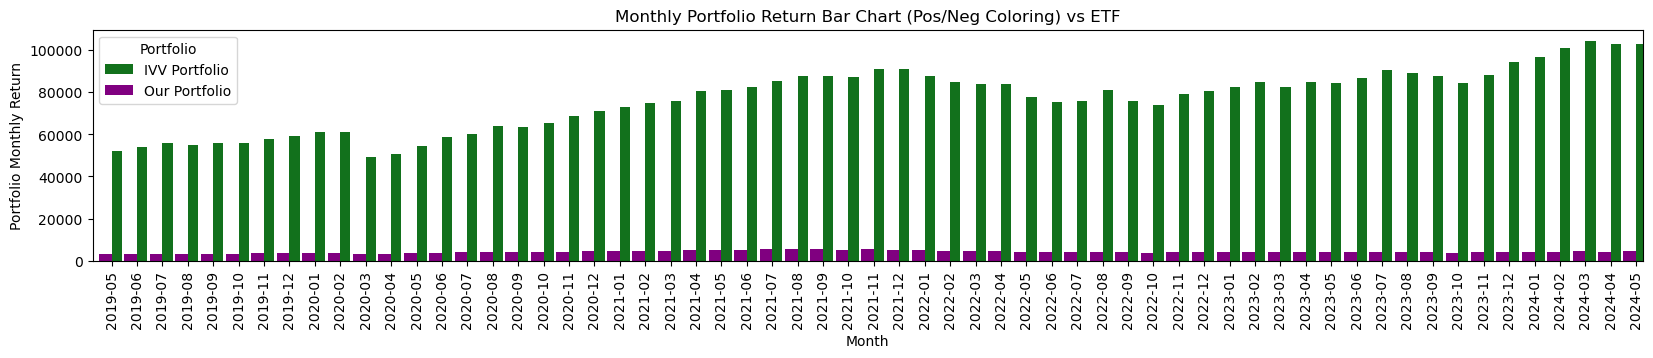

In [147]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ivv_port is an instance of the Portfolio class
monthly_etf_mean = ivv_port.get_etf_monthly_mean()["Portfolio Monthly Return"]
monthly_portfolio_mean = ivv_port.get_weighted_port_monthly_mean()["Portfolio Monthly Return"]

# Prepare data for plotting
monthly_port_return = pd.DataFrame({'IVV Portfolio': monthly_etf_mean, 'Our Portfolio': monthly_portfolio_mean})
colors = {'IVV Portfolio': monthly_port_return['IVV Portfolio'] >= 0, 'Our Portfolio': monthly_port_return['Our Portfolio'] >= 0}
monthly_port_return.index = monthly_port_return.index.to_period('M').astype(str)

# Plot the information
fig, ax = plt.subplots(figsize=(20, 3))
monthly_port_return['IVV Portfolio'].plot(kind='bar', color=colors['IVV Portfolio'].map({True: 'g', False: 'r'}), width=0.4, position=0, label='IVV Portfolio', ax=ax)
monthly_port_return['Our Portfolio'].plot(kind='bar', color=colors['Our Portfolio'].map({True: 'purple', False: 'r'}), width=0.5, position=1, label='Our Portfolio', ax=ax)

plt.title("Monthly Portfolio Return Bar Chart (Pos/Neg Coloring) vs ETF")
plt.xlabel("Month")
plt.ylabel("Portfolio Monthly Return")
plt.legend(title='Portfolio')
plt.xticks(rotation=90)
plt.show()


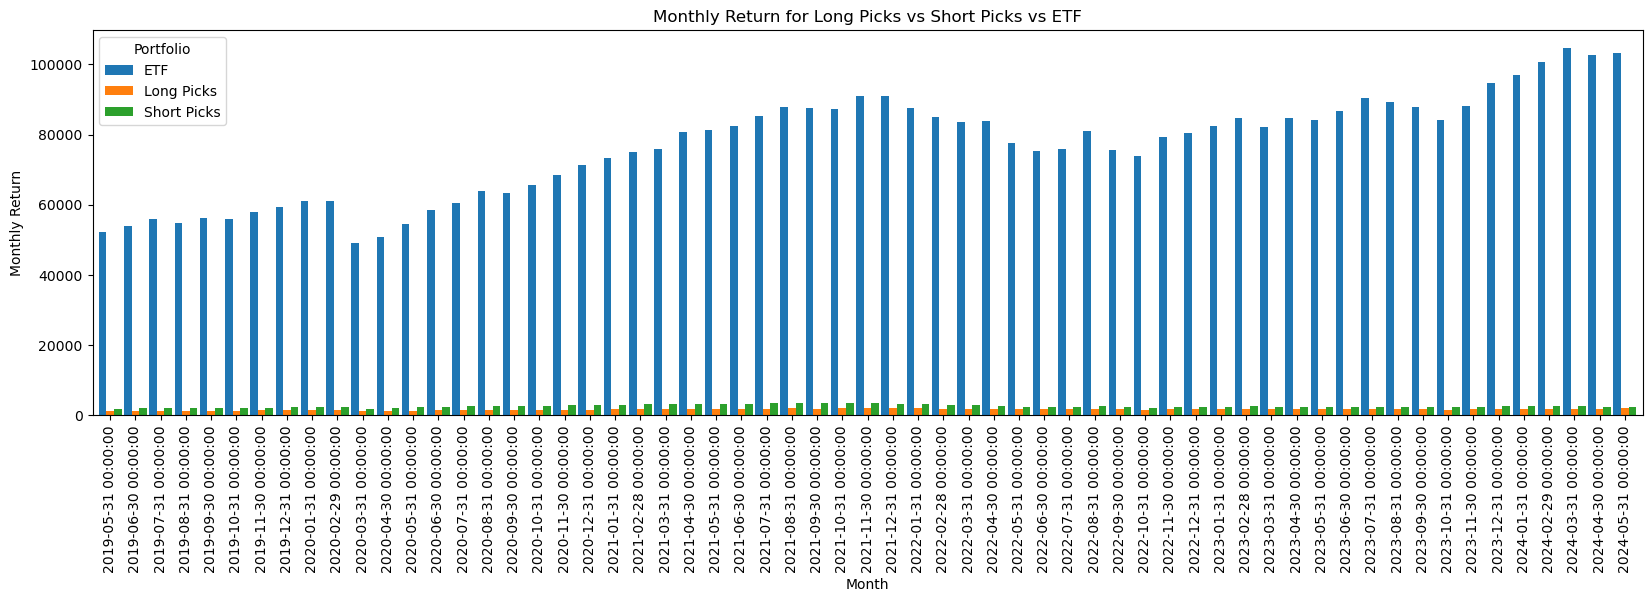

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming ivv_port is an instance of the Portfolio class
monthly_etf_mean = ivv_port.get_etf_monthly_mean()["Portfolio Monthly Return"]
long_picks_mean = ivv_port.get_monthly_info(ivv_port.get_largest_basket())["Portfolio Monthly Return"]
short_picks_mean = ivv_port.get_monthly_info(ivv_port.get_smallest_basket())["Portfolio Monthly Return"]

# Prepare data for plotting
monthly_returns = pd.DataFrame({
    'ETF': monthly_etf_mean,
    'Long Picks': long_picks_mean,
    'Short Picks': short_picks_mean
}).dropna()

# Plot the information
fig, ax = plt.subplots(figsize=(20, 5))
monthly_returns.plot(kind='bar', ax=ax, width=0.9)  # Adjust the width parameter to make the bars thicker
plt.title("Monthly Return for Long Picks vs Short Picks vs ETF")
plt.xlabel("Month")
plt.ylabel("Monthly Return")
plt.legend(title='Portfolio')
plt.xticks(rotation=90)
plt.show()


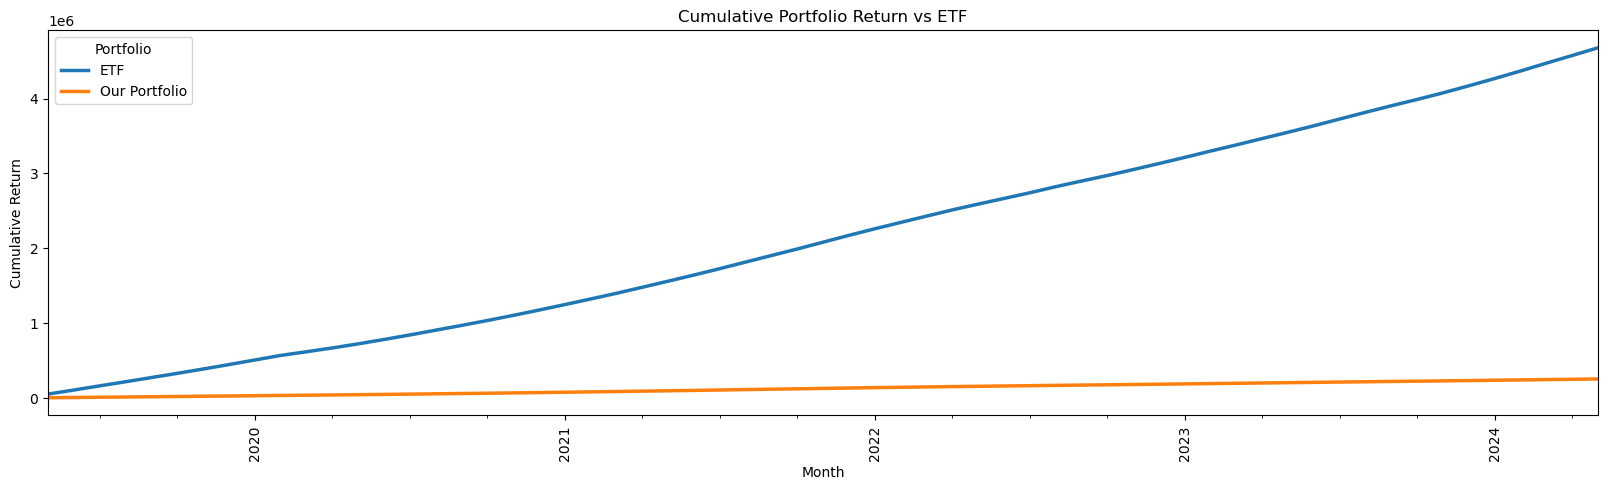

In [157]:

# Assuming ivv_port is an instance of the Portfolio class
monthly_etf_mean = ivv_port.get_etf_monthly_mean()
monthly_portfolio_mean = ivv_port.get_weighted_port_monthly_mean()

# Prepare data for plotting cumulative returns
cumulative_returns = pd.DataFrame({
    'ETF': monthly_etf_mean['Cumulative Monthly Return'],
    'Our Portfolio': monthly_portfolio_mean['Cumulative Monthly Return']
}).dropna()

# Convert index to month-year format for x-axis
cumulative_returns.index = cumulative_returns.index.to_period('M')

# Plot the information with thicker lines
fig, ax = plt.subplots(figsize=(20, 5))
cumulative_returns.plot(ax=ax, linewidth=2.5)  # Increase the linewidth to make the lines thicker
plt.title("Cumulative Portfolio Return vs ETF")
plt.xlabel("Month")
plt.ylabel("Cumulative Return")
plt.legend(title='Portfolio')
plt.xticks(rotation=90)
plt.show()


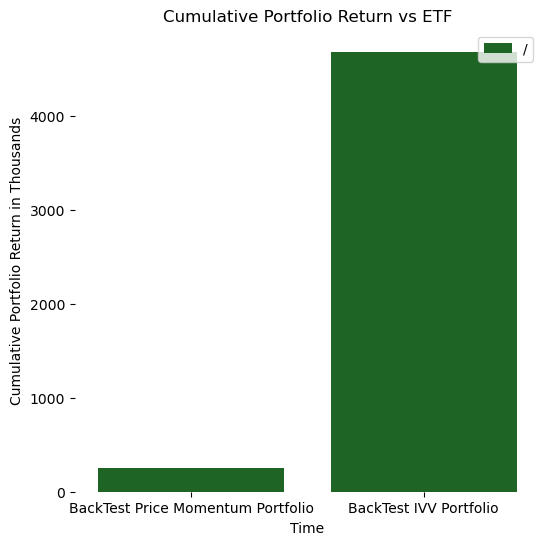

In [150]:
# Retrieve data for plotting
backtest_data = ivv_port.get_backtest_comparison()
x_values = backtest_data.index.tolist()
y_values = backtest_data['Final Cumulative Value'] / 1000

# Define the plot variables
cumulative_return_port_etf = [
    {
        'color_codes': 'dark',
        'x_values': x_values,
        'y_values': y_values,
        'data': backtest_data,
        'label': "/",
        'color': "g"
    }
]

# Plot the information
ivv_port.plot_information(
    plot_vars=cumulative_return_port_etf,
    xlabel="Time",
    ylabel="Cumulative Portfolio Return in Thousands",
    title='Cumulative Portfolio Return vs ETF',
    figsize=(6, 6),
    xlim=None
)

